In [1]:
import numpy as np
import cooltools
import cooler
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from collections import defaultdict

from scipy.stats import zscore
import pandas as pd

from numutils import observed_over_expected, adaptive_coarsegrain
import colormaps

In [2]:
# Functions
def getRealMatrix(mcool, resolution, chrom, start, end):
    coolres = "%s::resolutions/%d" % (path, resolution)
    clr = cooler.Cooler(coolres)
    region = (chrom, start, end)
    mat = clr.matrix(balance=True).fetch(region)
    mat_raw = clr.matrix(balance=False).fetch(region)
    mat_cg = adaptive_coarsegrain(mat, mat_raw)
    return mat, mat_cg

def getOrcaMatrix(path_prefix, width):
    path = "%s_%s.txt" % (path_prefix, width)
    mat = np.loadtxt(path,comments="#")
    return mat

def get_observed_over_expected(A):
    A = mat_cg
    A[~np.isfinite(A)] = 0
    mask = A.sum(axis=0) > 0
    OE, _, _, _ = observed_over_expected(A, mask)
    return OE

def get_oberserd_over_expected_by_hand(A):
    """
    A : a simple numpy matrix
    Returns Observed over expected
    """
    data = np.zeros_like(A)
    N = A.shape[0]
    mean_diag = defaultdict()
    for d in range(1,N):
        num_valid = 0
        sum_diag = 0
        for i in range(0,N-d):
            if np.isfinite(A[i, i+d]):
                sum_diag +=  A[i, i+d]
                num_valid += 1
        mean_diag[d] = sum_diag/num_valid

    for i in range(0,N):
        data[i,i] = 1
        for j in range(i+1,N):
            d = j-i
            if mean_diag[d]:
                if np.isfinite(A[i, j]):
                    data[i, j] = A[i, j]/mean_diag[d]
                else:
                    data[i, j] = 1
                data[j, i] = data[i, j]
    return data, mean_diag

def get_expected_cis(path, resolution, chrom, start, end):
    """
    From a cool matrix, computed expected in region chrom:start-end 
    using cooltools expected_cis
    Returns expected_cis as a dataframe
    """
    coolres = "%s::resolutions/%d" % (path, resolution)
    clr = cooler.Cooler(coolres)
    view_df = pd.DataFrame({'chrom': [chrom],
                        'start': [start],
                        'end': [end],
                        'name': [chrom]})
    expected = cooltools.expected_cis(clr, view_df, intra_only=True)
    return expected

def get_oberserd_over_expected_from_expected_cis(A, expected_cis, ignore_diags=2):
    """
    A: a simple numpy matrix from the cool matrix
    expected_cis: a dictionnary with diagonal as key and the expected as value
    Returns expected_cis as a dataframe
    """
    data = np.zeros_like(A)
    N = A.shape[0]
    for i in range(0,N):
        for j in range(i,N):
            d = j-i                
            # The obsExp value is computed only if 
            #  - the corresponding diagonal is not ignored
            #  - mean for diagonal d has been computed and is finite
            if (d >= ignore_diags and d in expected_cis 
                and np.isfinite(expected_cis[d])):
                if np.isfinite(A[i, j]):
                    data[i, j] = A[i, j]/expected_cis[d]
                else:
                    data[i, j] = 1
                data[j, i] = data[i, j]
            else:
                data[i, j] = 1
                data[j, i] = data[i, j]
    return data

In [3]:
path="../../data/4DNFI9GMP2J8.rebinned.mcool"
orca_path_prefix = "../../Orca/human_ESC/human_ESC_orca_predictions"

In [4]:
resolution=128_000
chrom, start, end = "chr9", 94_900_000, 126_900_000
mat, mat_cg = getRealMatrix(path, resolution, chrom, start, end)
realOE =  get_observed_over_expected(mat_cg)
predOE = getOrcaMatrix(orca_path_prefix, "32Mb")

/home/tfaraut/mnt/bioinfogeno/dynawork/Stages/Florian/IA3D/notebooks/numutils.py:282: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


In [5]:
realOEhand, expected = get_oberserd_over_expected_by_hand(mat_cg)

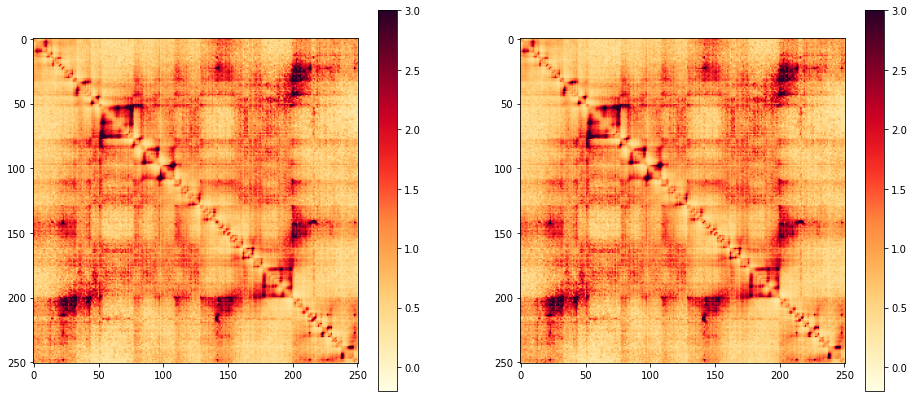

In [7]:
plt.figure(figsize=(16,7))
ax = plt.subplot(121)
plt.imshow(realOE, cmap=colormaps.hnh_cmap_ext5, vmin=-0.2, vmax=3)
plt.colorbar()
plt.subplot(122, sharex=ax, sharey=ax)
plt.imshow(realOEhand, cmap=colormaps.hnh_cmap_ext5, vmin=-0.2, vmax=3)
plt.colorbar()    

In [8]:
expected = get_expected_cis(path, resolution, chrom, start, end)

In [9]:
expected.head()

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg,balanced.avg.smoothed,balanced.avg.smoothed.agg
0,chr9,chr9,0,251,NaN,NaN,NaN,NaN,NaN,NaN
1,chr9,chr9,1,250,NaN,NaN,NaN,NaN,0.000531,0.000531
2,chr9,chr9,2,249,1290287.0,12.439734,5181.875502,0.049959,0.045982,0.045982
3,chr9,chr9,3,248,778472.0,7.641596,3139.000000,0.030813,0.029831,0.029831
4,chr9,chr9,4,247,531481.0,5.272068,2151.744939,0.021344,0.020712,0.020712


In [10]:
nested_dict = {
    col: {row['dist']: row[col] for _, row in expected.iterrows()} 
    for col in ["balanced.avg", "balanced.avg.smoothed", "balanced.avg.smoothed.agg"]  # Skip the first column (ID)
}

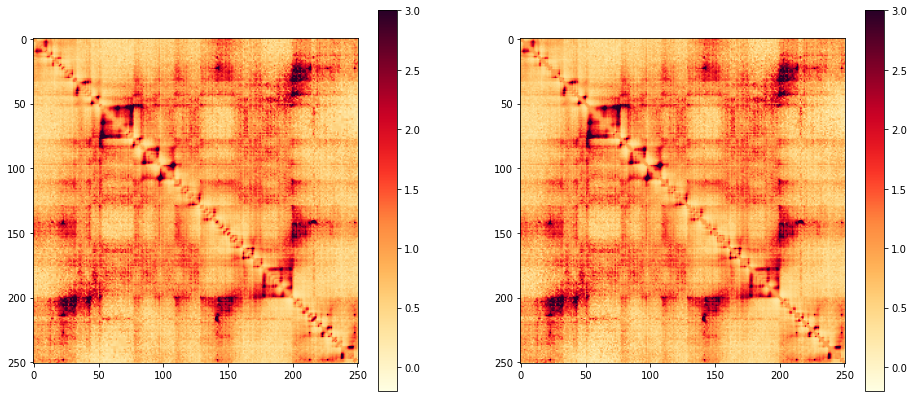

In [11]:
OE_balanced_avg = get_oberserd_over_expected_from_expected_cis(mat, nested_dict['balanced.avg'])
plt.figure(figsize=(16,7))
ax = plt.subplot(121)
plt.imshow(realOE, cmap=colormaps.hnh_cmap_ext5, vmin=-0.2, vmax=3)
plt.colorbar()
plt.subplot(122, sharex=ax, sharey=ax)
plt.imshow(OE_balanced_avg, cmap=colormaps.hnh_cmap_ext5, vmin=-0.2, vmax=3)
plt.colorbar() 

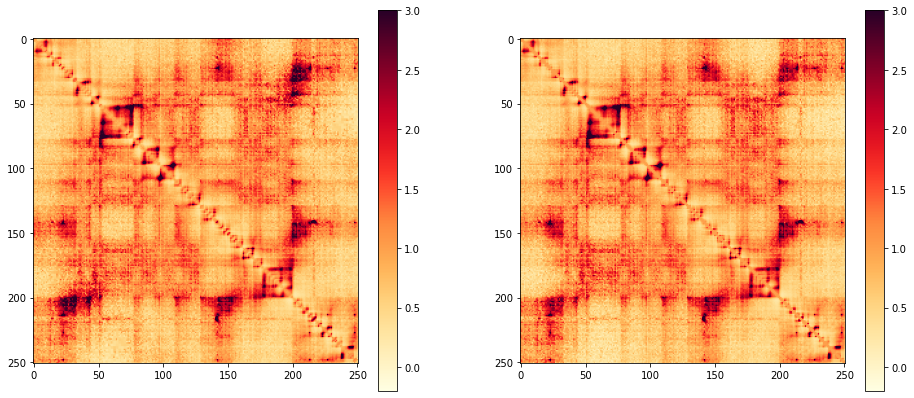

In [12]:
OE_balanced_avg_smoothed = get_oberserd_over_expected_from_expected_cis(mat, nested_dict['balanced.avg.smoothed'])
plt.figure(figsize=(16,7))
ax = plt.subplot(121)
plt.imshow(realOE, cmap=colormaps.hnh_cmap_ext5, vmin=-0.2, vmax=3)
plt.colorbar()
plt.subplot(122, sharex=ax, sharey=ax)
plt.imshow(OE_balanced_avg_smoothed, cmap=colormaps.hnh_cmap_ext5, vmin=-0.2, vmax=3)
plt.colorbar()

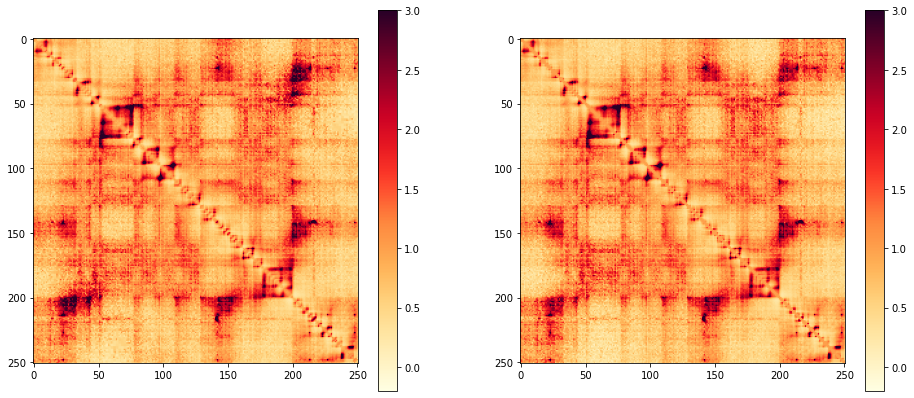

In [13]:
OE_balanced_avg_smoothed_agg = get_oberserd_over_expected_from_expected_cis(mat, nested_dict['balanced.avg.smoothed.agg'])
plt.figure(figsize=(16,7))
ax = plt.subplot(121)
plt.imshow(realOE, cmap=colormaps.hnh_cmap_ext5, vmin=-0.2, vmax=3)
plt.colorbar()
plt.subplot(122, sharex=ax, sharey=ax)
plt.imshow(OE_balanced_avg_smoothed_agg, cmap=colormaps.hnh_cmap_ext5, vmin=-0.2, vmax=3)
plt.colorbar()

In [14]:
resolution=32_000
chrom, start, end = "chr9", 80_900_000, 126_900_000
mat, mat_cg = getRealMatrix(path, resolution, chrom, start, end)
realOE =  get_observed_over_expected(mat_cg)

/home/tfaraut/mnt/bioinfogeno/dynawork/Stages/Florian/IA3D/notebooks/numutils.py:282: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


In [15]:
realOEhand, expected = get_oberserd_over_expected_by_hand(mat_cg)

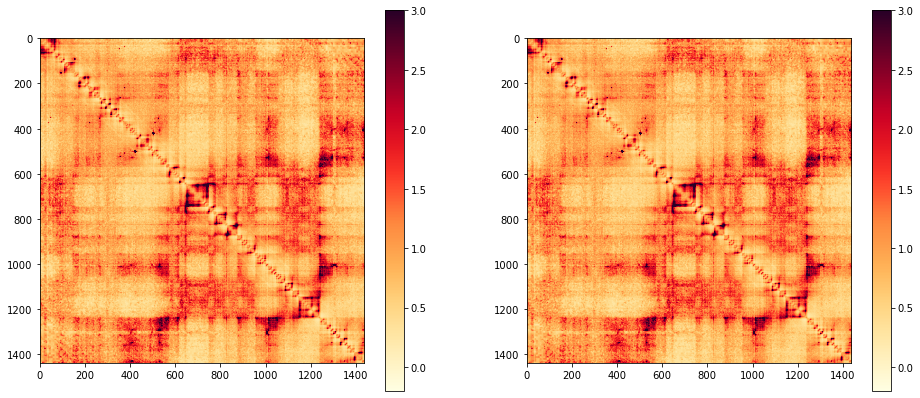

In [16]:
plt.figure(figsize=(16,7))
ax = plt.subplot(121)
plt.imshow(realOE, cmap=colormaps.hnh_cmap_ext5, vmin=-0.2, vmax=3)
plt.colorbar()
plt.subplot(122, sharex=ax, sharey=ax)
plt.imshow(realOEhand, cmap=colormaps.hnh_cmap_ext5, vmin=-0.2, vmax=3)
plt.colorbar()  

In [17]:
expected = get_expected_cis(path, resolution, chrom, start, end)

In [18]:
expected.head()

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg,balanced.avg.smoothed,balanced.avg.smoothed.agg
0,chr9,chr9,0,1436,NaN,NaN,NaN,NaN,NaN,NaN
1,chr9,chr9,1,1433,NaN,NaN,NaN,NaN,0.000343,0.000343
2,chr9,chr9,2,1432,1517572.0,46.108542,1059.756983,0.032199,0.030191,0.030191
3,chr9,chr9,3,1431,1070797.0,32.751516,748.285814,0.022887,0.022367,0.022367
4,chr9,chr9,4,1430,850589.0,26.095789,594.817483,0.018249,0.017754,0.017754


In [19]:
nested_dict = {
    col: {row['dist']: row[col] for _, row in expected.iterrows()} 
    for col in ["balanced.avg", "balanced.avg.smoothed", "balanced.avg.smoothed.agg"]  # Skip the first column (ID)
}

/home/tfaraut/miniforge3/envs/cooltools/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


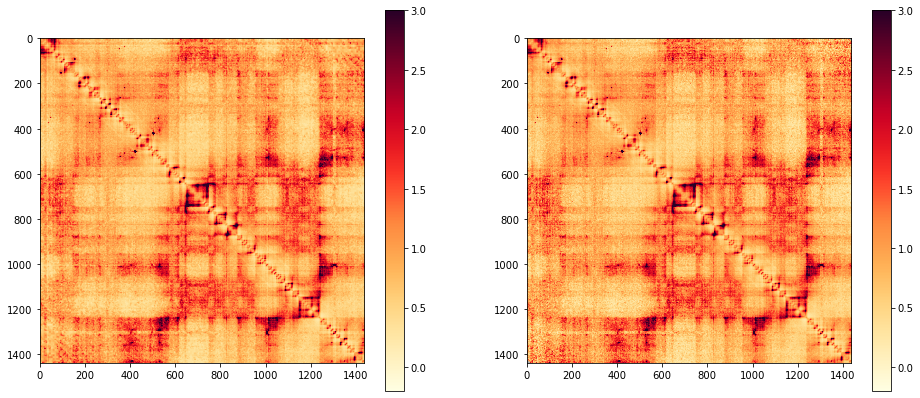

In [20]:
OE_balanced_avg = get_oberserd_over_expected_from_expected_cis(mat, nested_dict['balanced.avg'])
plt.figure(figsize=(16,7))
ax = plt.subplot(121)
plt.imshow(realOE, cmap=colormaps.hnh_cmap_ext5, vmin=-0.2, vmax=3)
plt.colorbar()
plt.subplot(122, sharex=ax, sharey=ax)
plt.imshow(OE_balanced_avg, cmap=colormaps.hnh_cmap_ext5, vmin=-0.2, vmax=3)
plt.colorbar() 